## IPP Temporal Codec (GOP I+P)
Sistemas Multimedia
Autores: 
Rafael de Jesus Bautista Hernandez
Saul David Ramos PAcheco
Alex Cesar Taquila Camasca

## Explicacion Teorica
El códec IPP es un esquema de compresión temporal basado en la estructura GOP (Group of Pictures)
Cada GOP comienza con un I‑frame (Intra), codificado sin referencia a otros frames, seguido de varios P‑frames (Predicted), que se codifican mediante predicción temporal

El proceso consiste en:
- I‑frame: se almacena directamente como referencia inicial
- Motion Estimation (ME): para cada P‑frame, se divide la imagen en bloques y se busca el desplazamiento (vector de movimiento) que minimiza el error respecto     al frame anterior reconstruido
- Motion Compensation (MC): se genera una predicción aplicando los vectores de movimiento al frame previo
- Residual computation: se calcula la diferencia entre el frame actual y su predicción
- Quantization: el residual se cuantiza mediante un factor q_step, controlando la pérdida y la compresión
- Reconstruction: el decodificador suma la predicción y el residual dequantizado para obtener el frame reconstruido
- PSNR & CR: se evalúa la calidad mediante PSNR y la eficiencia mediante la relación de compresión (CR)
  
Este enfoque reduce significativamente la redundancia temporal y permite observar cómo la calidad se degrada a lo largo de los P‑frames según el nivel de cuantización

In [1]:
import os
import shutil

BASE_DIR   = "/tmp/IPP"
FRAMES_DIR = os.path.join(BASE_DIR, "frames")
COMP_DIR   = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR= os.path.join(BASE_DIR, "results")

# Limpiar y recrear estructura
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(COMP_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Estructura creada en:", BASE_DIR)

Estructura creada en: /tmp/IPP


Imagen guardada en /tmp/input.png


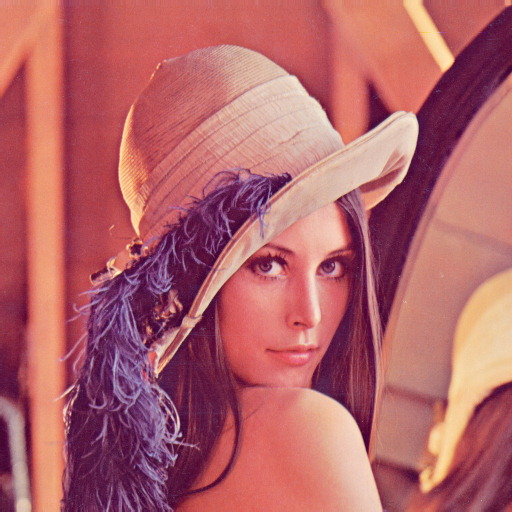

In [2]:
import requests
from PIL import Image
from io import BytesIO

url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img.save("/tmp/input.png")

print("Imagen guardada en /tmp/input.png")
img

In [3]:
from PIL import Image
import numpy as np
import os

img = Image.open("/tmp/input.png").convert("RGB")
arr = np.array(img)

N_FRAMES = 50  # numero de frames a crear

for i in range(N_FRAMES):
    Image.fromarray(arr).save(os.path.join(FRAMES_DIR, f"frame_{i:03d}.png"))

print("Frames generados en:", FRAMES_DIR)
print("Total frames:", len(os.listdir(FRAMES_DIR)))

Frames generados en: /tmp/IPP/frames
Total frames: 50


In [4]:
%%writefile ../src/IPP.py
import os
import time
import argparse
import numpy as np
from PIL import Image

# ==========================
#   RUTAS BASE
# ==========================

BASE_DIR   = "/tmp/IPP"
FRAMES_DIR = os.path.join(BASE_DIR, "frames")
COMP_DIR   = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR= os.path.join(BASE_DIR, "results")

# ==========================
#   UTILIDADES
# ==========================

def load_frames_from_folder(frames_dir):
    files = sorted([f for f in os.listdir(frames_dir) if f.lower().endswith((".png",".jpg",".jpeg"))])
    frames = []
    for f in files:
        img = Image.open(os.path.join(frames_dir, f)).convert("RGB")
        frames.append(np.array(img, dtype=np.uint8))
    return frames, files

def save_frames_to_folder(frames, out_dir, prefix="recon_"):
    os.makedirs(out_dir, exist_ok=True)
    for i, fr in enumerate(frames):
        Image.fromarray(fr.astype(np.uint8)).save(os.path.join(out_dir, f"{prefix}{i:03d}.png"))

def compute_psnr(orig, recon, data_range=255.0):
    orig_f = orig.astype(np.float32)
    recon_f = recon.astype(np.float32)
    mse = np.mean((orig_f - recon_f)**2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(data_range / np.sqrt(mse))

def quantize_residual(residual, q_step):
    return np.round(residual / float(q_step)).astype(np.int16)

def dequantize_residual(res_q, q_step):
    return (res_q.astype(np.int16) * int(q_step)).astype(np.int16)

def compute_residual(target, predicted):
    return target.astype(np.int16) - predicted.astype(np.int16)

def reconstruct_from_residual(predicted, residual):
    rec = predicted.astype(np.int16) + residual
    return np.clip(rec, 0, 255).astype(np.uint8)

# ==========================
#   MOTION ESTIMATION
# ==========================

def block_motion_estimation_mv(ref, target, block_size=16, search_range=2):
    H, W, _ = ref.shape
    H_blocks = H // block_size
    W_blocks = W // block_size
    mv = np.zeros((H_blocks, W_blocks, 2), dtype=np.int16)

    ref_f = ref.astype(np.float32)
    tgt_f = target.astype(np.float32)

    for by in range(H_blocks):
        for bx in range(W_blocks):
            y0 = by * block_size
            x0 = bx * block_size
            block_t = tgt_f[y0:y0+block_size, x0:x0+block_size, :]

            best_err = np.inf
            best_dy = 0
            best_dx = 0

            for dy in range(-search_range, search_range+1):
                for dx in range(-search_range, search_range+1):
                    yy = y0 + dy
                    xx = x0 + dx
                    if yy < 0 or xx < 0 or yy + block_size > H or xx + block_size > W:
                        continue
                    block_r = ref_f[yy:yy+block_size, xx:xx+block_size, :]
                    err = np.mean((block_t - block_r)**2)
                    if err < best_err:
                        best_err = err
                        best_dy = dy
                        best_dx = dx

            mv[by, bx, 0] = best_dy
            mv[by, bx, 1] = best_dx

    return mv

def apply_motion_vectors_mv(ref, motion_vectors, block_size=16):
    H, W, _ = ref.shape
    H_blocks, W_blocks, _ = motion_vectors.shape
    ref_f = ref.astype(np.float32)
    pred = np.zeros_like(ref_f)

    for by in range(H_blocks):
        for bx in range(W_blocks):
            y0 = by * block_size
            x0 = bx * block_size
            dy, dx = motion_vectors[by, bx]
            yy = y0 + dy
            xx = x0 + dx
            block_ref = ref_f[yy:yy+block_size, xx:xx+block_size, :]
            pred[y0:y0+block_size, x0:x0+block_size, :] = block_ref

    return np.clip(pred, 0, 255).astype(np.uint8)

# ==========================
#   PARÁMETROS IPP
# ==========================

GOP_SIZE = 16
q_step   = 32

USE_MV   = True
MV_BLOCK = 16
MV_RANGE = 2

# ==========================
#   ENCODER
# ==========================

def encoder_main():
    os.makedirs(COMP_DIR, exist_ok=True)

    frames, filenames = load_frames_from_folder(FRAMES_DIR)
    if not frames:
        print(f"No hay frames en la carpeta {FRAMES_DIR}.")
        return

    num_frames = len(frames)
    num_gops   = (num_frames + GOP_SIZE - 1) // GOP_SIZE

    t0 = time.time()

    for g in range(num_gops):
        start = g * GOP_SIZE
        end   = min(start + GOP_SIZE, num_frames)
        gop       = frames[start:end]
        gop_names = filenames[start:end]

        i_frame = gop[0]
        prev_rec = i_frame.copy()

        motion_vectors_list = []
        residuals_q = []

        for t in range(1, len(gop)):
            curr = gop[t]

            if USE_MV:
                mv   = block_motion_estimation_mv(prev_rec, curr, block_size=MV_BLOCK, search_range=MV_RANGE)
                pred = apply_motion_vectors_mv(prev_rec, mv, block_size=MV_BLOCK)
            else:
                mv   = None
                pred = prev_rec

            residual   = compute_residual(curr, pred)
            residual_q = quantize_residual(residual, q_step)

            motion_vectors_list.append(mv)
            residuals_q.append(residual_q)

            prev_rec = np.clip(pred.astype(np.int16) + (residual_q.astype(np.int16) * q_step), 0, 255).astype(np.uint8)

        out_path = os.path.join(COMP_DIR, f"gop_{g:03d}.npz")
        np.savez(
            out_path,
            i_frame=i_frame,
            motion_vectors=np.array(motion_vectors_list, dtype=object),
            residuals_q=np.array(residuals_q, dtype=object),
            q_step=q_step,
            filenames=np.array(gop_names, dtype=object),
            use_mv=USE_MV
        )

        print(f"GOP {g} guardado en {out_path}")

    t1 = time.time()
    print("Codificación completa en {:.2f} s".format(t1 - t0))

# ==========================
#   DECODER
# ==========================

def decoder_main():
    os.makedirs(RESULTS_DIR, exist_ok=True)

    gop_files = sorted([f for f in os.listdir(COMP_DIR) if f.startswith("gop_") and f.endswith(".npz")])
    all_recon = []

    t0 = time.time()
    for gf in gop_files:
        data = np.load(os.path.join(COMP_DIR, gf), allow_pickle=True)

        i_frame     = data["i_frame"]
        residuals_q = data["residuals_q"]
        q_step_local= int(data["q_step"])

        if "motion_vectors" in data:
            motion_vectors_arr = data["motion_vectors"]
        else:
            motion_vectors_arr = [None] * len(residuals_q)

        prev_rec = i_frame.copy()
        recon_frames = [prev_rec]

        for idx, res_q in enumerate(residuals_q):
            mv = motion_vectors_arr[idx]

            if mv is None:
                pred = prev_rec
            else:
                pred = apply_motion_vectors_mv(prev_rec, mv, block_size=16)

            residual = dequantize_residual(res_q, q_step_local)
            rec      = reconstruct_from_residual(pred, residual)

            recon_frames.append(rec)
            prev_rec = rec

        gop_index = gf.split("_")[1].split(".")[0]
        save_frames_to_folder(recon_frames, RESULTS_DIR, prefix=f"gop{gop_index}_")
        all_recon.extend(recon_frames)
        print(f"GOP {gf} decodificado, frames: {len(recon_frames)}")

    t1 = time.time()
    print("Decodificación completa en {:.2f} s".format(t1 - t0))

# ==========================
#   TEST (PSNR y CR)
# ==========================

def test_main():
    comp_files = sorted([f for f in os.listdir(COMP_DIR) if f.startswith("gop_") and f.endswith(".npz")])

    orig_frames, orig_names = load_frames_from_folder(FRAMES_DIR)

    recon_files = sorted([f for f in os.listdir(RESULTS_DIR) if f.startswith("gop") and f.endswith(".png")])
    recon_frames = [np.array(Image.open(os.path.join(RESULTS_DIR,f)).convert("RGB"), dtype=np.uint8) for f in recon_files]

    n = min(len(orig_frames), len(recon_frames))
    psnrs = []
    for i in range(n):
        p = compute_psnr(orig_frames[i], recon_frames[i])
        psnrs.append(p)
        print(f"Frame {i:03d} PSNR = {p:.2f} dB")

    mean_psnr = float(np.mean([v for v in psnrs if np.isfinite(v)])) if psnrs else 0.0
    print(f"\nPSNR medio (sin contar inf) = {mean_psnr:.2f} dB")

    total_orig = sum(fr.nbytes for fr in orig_frames)
    total_comp = sum(os.path.getsize(os.path.join(COMP_DIR,f)) for f in comp_files) if comp_files else 1
    cr = (total_orig * 1.0) / total_comp
    print(f"Tamaño original: {total_orig} bytes")
    print(f"Tamaño comprimido (sum gops): {total_comp} bytes")
    print(f"CR ≈ {cr:.2f}")

# ==========================
#   CLI PRINCIPAL
# ==========================

def main():
    parser = argparse.ArgumentParser(description="IPP temporal codec (GOP I+P)")
    subparsers = parser.add_subparsers(dest="command", required=True)

    subparsers.add_parser("encode", help="Codificar secuencia (frames -> compressed)")
    subparsers.add_parser("decode", help="Decodificar secuencia (compressed -> results)")
    subparsers.add_parser("test", help="Calcular PSNR y CR")

    args = parser.parse_args()

    if args.command == "encode":
        encoder_main()
    elif args.command == "decode":
        decoder_main()
    elif args.command == "test":
        test_main()
    else:
        parser.print_help()

if __name__ == "__main__":
    main()

Overwriting ../src/IPP.py


In [5]:
!python ../src/IPP.py -h

usage: IPP.py [-h] {encode,decode,test} ...

IPP temporal codec (GOP I+P)

positional arguments:
  {encode,decode,test}
    encode              Codificar secuencia (frames -> compressed)
    decode              Decodificar secuencia (compressed -> results)
    test                Calcular PSNR y CR

options:
  -h, --help            show this help message and exit


In [6]:
!python ../src/IPP.py encode

GOP 0 guardado en /tmp/IPP/compressed/gop_000.npz
GOP 1 guardado en /tmp/IPP/compressed/gop_001.npz
GOP 2 guardado en /tmp/IPP/compressed/gop_002.npz
GOP 3 guardado en /tmp/IPP/compressed/gop_003.npz
Codificación completa en 6.39 s


In [7]:
!python ../src/IPP.py decode

GOP gop_000.npz decodificado, frames: 16
GOP gop_001.npz decodificado, frames: 16
GOP gop_002.npz decodificado, frames: 16
GOP gop_003.npz decodificado, frames: 2
Decodificación completa en 4.09 s


In [8]:
!python ../src/IPP.py test

Frame 000 PSNR = inf dB
Frame 001 PSNR = inf dB
Frame 002 PSNR = inf dB
Frame 003 PSNR = inf dB
Frame 004 PSNR = inf dB
Frame 005 PSNR = inf dB
Frame 006 PSNR = inf dB
Frame 007 PSNR = inf dB
Frame 008 PSNR = inf dB
Frame 009 PSNR = inf dB
Frame 010 PSNR = inf dB
Frame 011 PSNR = inf dB
Frame 012 PSNR = inf dB
Frame 013 PSNR = inf dB
Frame 014 PSNR = inf dB
Frame 015 PSNR = inf dB
Frame 016 PSNR = inf dB
Frame 017 PSNR = inf dB
Frame 018 PSNR = inf dB
Frame 019 PSNR = inf dB
Frame 020 PSNR = inf dB
Frame 021 PSNR = inf dB
Frame 022 PSNR = inf dB
Frame 023 PSNR = inf dB
Frame 024 PSNR = inf dB
Frame 025 PSNR = inf dB
Frame 026 PSNR = inf dB
Frame 027 PSNR = inf dB
Frame 028 PSNR = inf dB
Frame 029 PSNR = inf dB
Frame 030 PSNR = inf dB
Frame 031 PSNR = inf dB
Frame 032 PSNR = inf dB
Frame 033 PSNR = inf dB
Frame 034 PSNR = inf dB
Frame 035 PSNR = inf dB
Frame 036 PSNR = inf dB
Frame 037 PSNR = inf dB
Frame 038 PSNR = inf dB
Frame 039 PSNR = inf dB
Frame 040 PSNR = inf dB
Frame 041 PSNR =

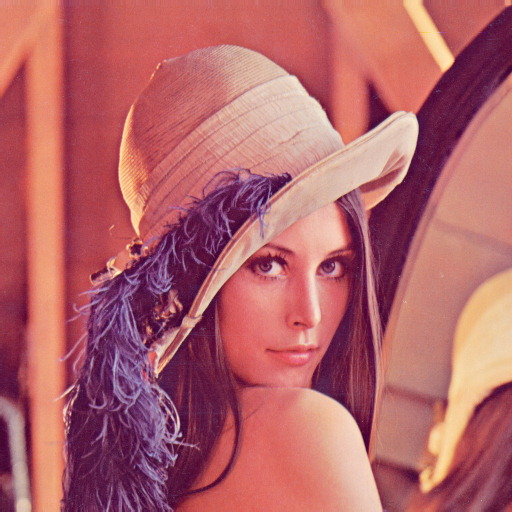

In [9]:
from IPython.display import Image as IPyImage, display
import os

# Primer frame del primer GOP
recon_path = os.path.join(RESULTS_DIR, "gop000_000.png")

if os.path.exists(recon_path):
    display(IPyImage(filename=recon_path))
else:
    print("No se encontró", recon_path)

## Comparacion

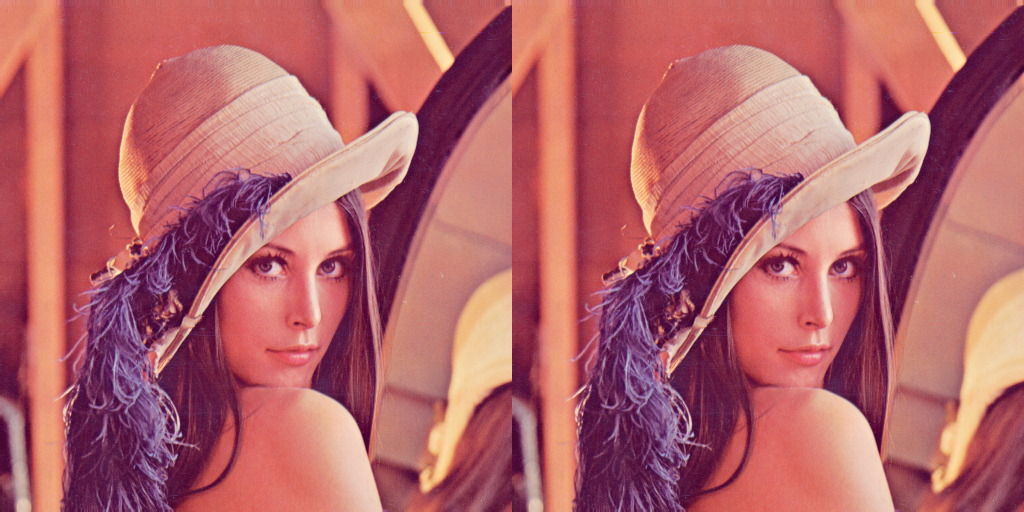

In [13]:
from PIL import Image
import numpy as np

orig_path = os.path.join(FRAMES_DIR, "frame_000.png")
recon_path = os.path.join(RESULTS_DIR, "gop003_001.png")

orig  = np.array(Image.open(orig_path).convert("RGB"))
recon = np.array(Image.open(recon_path).convert("RGB"))

concat = np.hstack((orig, recon))
display(Image.fromarray(concat))